[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/flax/blob/main/docs/mnist_tutorial.ipynb)
[![Open On GitHub](https://img.shields.io/badge/Open-on%20GitHub-blue?logo=GitHub)](https://github.com/google/flax/blob/main/docs/mnist_tutorial.ipynb)

# MNIST Tutorial

Welcome to NNX! This tutorial will guide you through building and training a simple convolutional 
neural network (CNN) on the MNIST dataset using the NNX API. NNX is a Python neural network library
built upon [JAX](https://github.com/google/jax) and currently offered as an experimental module within 
[Flax](https://github.com/google/flax).

## 1. Install NNX

Since NNX is under active development, we recommend using the latest version from the Flax GitHub repository:

In [ ]:
# TODO: Fix text descriptions in this tutorial
!pip install git+https://github.com/google/flax.git

## 2. Load the MNIST Dataset

We'll use TensorFlow Datasets (TFDS) for loading and preparing the MNIST dataset:

In [1]:
import tensorflow_datasets as tfds  # TFDS for MNIST
import tensorflow as tf  # TensorFlow operations

tf.random.set_seed(0)  # set random seed for reproducibility

num_epochs = 10
batch_size = 32

train_ds: tf.data.Dataset = tfds.load('mnist', split='train')
test_ds: tf.data.Dataset = tfds.load('mnist', split='test')

train_ds = train_ds.map(
  lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255,
    'label': sample['label'],
  }
)  # normalize train set
test_ds = test_ds.map(
  lambda sample: {
    'image': tf.cast(sample['image'], tf.float32) / 255,
    'label': sample['label'],
  }
)  # normalize test set

# create shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from
train_ds = train_ds.repeat(num_epochs).shuffle(1024)
# group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency
train_ds = train_ds.batch(batch_size, drop_remainder=True).prefetch(1)
# create shuffled dataset by allocating a buffer size of 1024 to randomly draw elements from
test_ds = test_ds.shuffle(1024)
# group into batches of batch_size and skip incomplete batch, prefetch the next sample to improve latency
test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

## 3. Define the Network with NNX

Create a convolutional neural network with NNX by subclassing `nnx.Module`.

In [2]:
from flax.experimental import nnx  # NNX API

class CNN(nnx.Module):
  """A simple CNN model."""

  def __init__(self, *, rngs: nnx.Rngs):
    self.conv1 = nnx.Conv(
      in_features=1, out_features=32, kernel_size=(3, 3), rngs=rngs
    )
    self.conv2 = nnx.Conv(
      in_features=32, out_features=64, kernel_size=(3, 3), rngs=rngs
    )
    self.linear1 = nnx.Linear(in_features=3136, out_features=256, rngs=rngs)
    self.linear2 = nnx.Linear(in_features=256, out_features=10, rngs=rngs)

  def __call__(self, x):
    x = self.conv1(x)
    x = nnx.relu(x)
    x = nnx.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = self.conv2(x)
    x = nnx.relu(x)
    x = nnx.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = self.linear1(x)
    x = nnx.relu(x)
    x = self.linear2(x)
    return x


model = CNN(rngs=nnx.Rngs(0))

print(f'model = {model}'[:500] + '\n...\n')  # print a part of the model
print(
  f'{model.conv1.kernel.value.shape = }'
)  # inspect the shape of the kernel of the first convolutional layer

model = CNN(
  conv1=Conv(
      in_features=1,
      out_features=32,
      kernel_size=(3, 3),
      strides=1,
      padding='SAME',
      input_dilation=1,
      kernel_dilation=1,
      feature_group_count=1,
      use_bias=True,
      mask_fn=None,
      dtype=None,
      param_dtype=<class 'jax.numpy.float32'>,
      precision=None,
      kernel_init=<function variance_scaling.<locals>.init at 0x35cbd31f0>,
      bias_init=<function zeros at 0x31d0a4f70>,
      conv_general_dilated=<funct
...

model.conv1.kernel.value.shape = (3, 3, 1, 32)


### Run model

Let's put our model to the test!  We'll perform a forward pass with arbitrary data and print the results.

In [3]:
import jax.numpy as jnp  # JAX NumPy

y = model(jnp.ones((1, 28, 28, 1)))
y

Array([[-0.06820839, -0.14743432,  0.00265857, -0.2173656 ,  0.16673787,
        -0.00923921, -0.06636689,  0.28341877,  0.33754364, -0.20142877]],      dtype=float32)

## 4. Create the `TrainState`

In Flax, a common practice is to use a dataclass to encapsulate the entire training state, which would allow you to simply pass only two arguments (the train state and batched data) to functions like `train_step`. The training state would typically contain an [`nnx.Optimizer`](https://flax.readthedocs.io/en/latest/api_reference/flax.experimental.nnx/training/optimizer.html#flax.experimental.nnx.optimizer.Optimizer) (which contains the step number, model and optimizer state) and an `nnx.Module` (for easier access to the model from the top-level of the train state). The training state can also be easily extended to add training and test metrics, as you will see in this tutorial (see [`nnx.metrics`](https://flax.readthedocs.io/en/latest/api_reference/flax.experimental.nnx/training/metrics.html#module-flax.experimental.nnx.metrics) for more detail on NNX's metric classes).

In [4]:
import dataclasses

@dataclasses.dataclass
class TrainState(nnx.GraphNode):
  optimizer: nnx.Optimizer
  model: CNN
  metrics: nnx.MultiMetric

We use `optax` to create an optimizer ([`adamw`](https://optax.readthedocs.io/en/latest/api/optimizers.html#optax.adamw)) and initialize the `nnx.Optimizer`. We use `nnx.MultiMetric` to keep track of both the accuracy and average loss for both training and test batches.

In [5]:
import optax

learning_rate = 0.005
momentum = 0.9
tx = optax.adamw(learning_rate, momentum)

state = TrainState(
  optimizer=nnx.Optimizer(model=model, tx=tx),
  model=model,
  metrics=nnx.MultiMetric(
    accuracy=nnx.metrics.Accuracy(), loss=nnx.metrics.Average()
  ),
)

## 5. Training step

We define a loss function using cross entropy loss (see more details in [`optax.softmax_cross_entropy_with_integer_labels()`](https://optax.readthedocs.io/en/latest/api/losses.html#optax.softmax_cross_entropy_with_integer_labels)) that our model will optimize over. In addition to the loss, the logits are also outputted since they will be used to calculate the accuracy metric during training and testing.

In [6]:
def loss_fn(model, batch):
  logits = model(batch['image'])
  loss = optax.softmax_cross_entropy_with_integer_labels(
    logits=logits, labels=batch['label']
  ).mean()
  return loss, logits

Next, we create the training step function. This function takes the `state` and a data `batch` and does the following:

* Computes the loss, logits and gradients with respect to the loss function using `nnx.value_and_grad`.
* Updates the training loss using the loss and updates the training accuracy using the logits and batch labels
* Updates model parameters and optimizer state by applying the gradient pytree to the optimizer.

In [7]:
@nnx.jit
def train_step(state: TrainState, batch):
  """Train for a single step."""
  grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(state.model, batch)
  state.metrics.update(values=loss, logits=logits, labels=batch['label'])
  state.optimizer.update(grads=grads)

The [`nnx.jit`](https://flax.readthedocs.io/en/latest/api_reference/flax.experimental.nnx/transforms.html#flax.experimental.nnx.jit) decorator traces the `train_step` function for just-in-time compilation with 
[XLA](https://www.tensorflow.org/xla), optimizing performance on 
hardware accelerators. `nnx.jit` is similar to [`jax.jit`](https://jax.readthedocs.io/en/latest/_autosummary/jax.jit.html#jax.jit),
except it can decorate functions that make stateful updates to NNX classes.

## 6. Metric Computation

Create a separate function to calculate loss and accuracy metrics for the test batch, since this will be outside the `train_step` function. Loss is determined using the `optax.softmax_cross_entropy_with_integer_labels` function, since we're reusing the loss function defined earlier.

In [8]:
@nnx.jit
def compute_test_metrics(*, state: TrainState, batch):
  loss, logits = loss_fn(state.model, batch)
  state.metrics.update(values=loss, logits=logits, labels=batch['label'])

## 7. Seed randomness

For reproducible dataset shuffling (using `tf.data.Dataset.shuffle`), set the TF random seed.

In [9]:
tf.random.set_seed(0)

## 8. Train and Evaluate

**Dataset Preparation:** create a "shuffled" dataset
- Repeat the dataset for the desired number of training epochs.
- Establish a 1024-sample buffer (holding the dataset's initial 1024 samples).
  Randomly draw batches from this buffer.
- As samples are drawn, replenish the buffer with subsequent dataset samples.

**Training Loop:** Iterate through epochs
- Sample batches randomly from the dataset.
- Execute an optimization step for each training batch.
- Calculate mean training metrics across batches within the epoch.
- With updated parameters, compute metrics on the test set.
- Log train and test metrics for visualization.

After 10 training and testing epochs, your model should reach approximately 99% accuracy.

In [10]:
num_steps_per_epoch = train_ds.cardinality().numpy() // num_epochs

metrics_history = {
  'train_loss': [],
  'train_accuracy': [],
  'test_loss': [],
  'test_accuracy': [],
}

for step, batch in enumerate(train_ds.as_numpy_iterator()):
  # Run the optimization for one step and make a stateful update to the following:
  # - the train state's model parameters
  # - the optimizer state
  # - the training loss and accuracy batch metrics
  train_step(state, batch)

  if (step + 1) % num_steps_per_epoch == 0:  # one training epoch has passed
    # Log training metrics
    for metric, value in state.metrics.compute().items():  # compute metrics
      metrics_history[f'train_{metric}'].append(value)  # record metrics
    state.metrics.reset()  # reset metrics for test set

    # Compute metrics on the test set after each training epoch
    for test_batch in test_ds.as_numpy_iterator():
      compute_test_metrics(state=state, batch=test_batch)

    # Log test metrics
    for metric, value in state.metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)
    state.metrics.reset()  # reset metrics for next training epoch

    print(
      f"train epoch: {(step+1) // num_steps_per_epoch}, "
      f"loss: {metrics_history['train_loss'][-1]}, "
      f"accuracy: {metrics_history['train_accuracy'][-1] * 100}"
    )
    print(
      f"test epoch: {(step+1) // num_steps_per_epoch}, "
      f"loss: {metrics_history['test_loss'][-1]}, "
      f"accuracy: {metrics_history['test_accuracy'][-1] * 100}"
    )

train epoch: 1, loss: 0.10209392756223679, accuracy: 96.92666625976562
test epoch: 1, loss: 0.05703972652554512, accuracy: 98.10697174072266
train epoch: 2, loss: 0.04372011497616768, accuracy: 98.63666534423828
test epoch: 2, loss: 0.041248343884944916, accuracy: 98.73797607421875
train epoch: 3, loss: 0.030999813228845596, accuracy: 99.0433349609375
test epoch: 3, loss: 0.05681844428181648, accuracy: 98.49759674072266
train epoch: 4, loss: 0.026122156530618668, accuracy: 99.25333404541016
test epoch: 4, loss: 0.04033380746841431, accuracy: 98.68789672851562
train epoch: 5, loss: 0.023744497448205948, accuracy: 99.31500244140625
test epoch: 5, loss: 0.05083772540092468, accuracy: 98.76802825927734
train epoch: 6, loss: 0.01850314810872078, accuracy: 99.45500183105469
test epoch: 6, loss: 0.04953562840819359, accuracy: 98.85816955566406
train epoch: 7, loss: 0.015862680971622467, accuracy: 99.51166534423828
test epoch: 7, loss: 0.0707646906375885, accuracy: 98.40745544433594
train epoc

## 9. Visualize Metrics

Use Matplotlib to create plots for loss and accuracy.

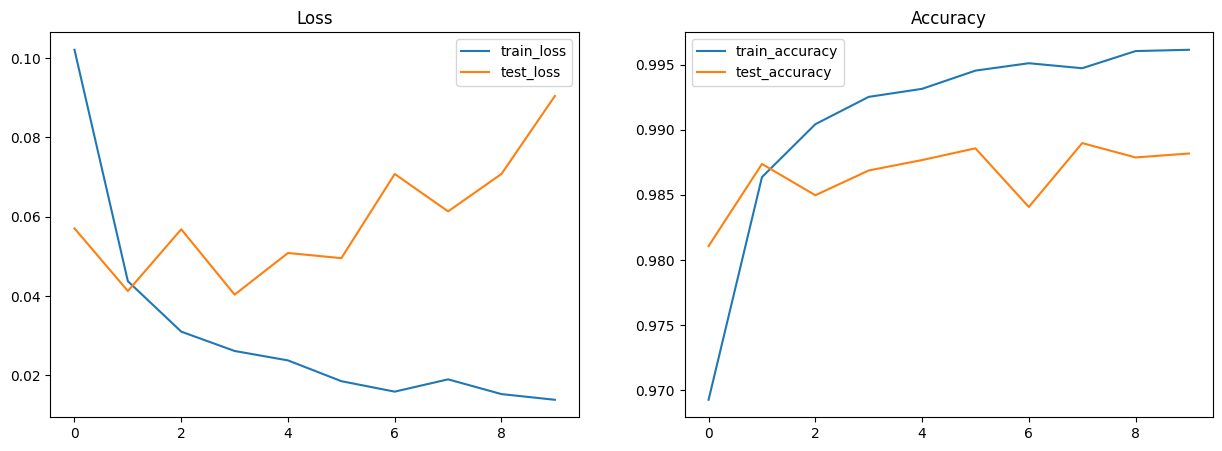

<Figure size 640x480 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train', 'test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()
plt.clf()

## 10. Perform inference on test set

Define a jitted inference function, `pred_step`, to generate predictions on the test set using the learned model parameters. This will enable you to visualize test images alongside their predicted labels for a qualitative assessment of model performance.

In [12]:
@nnx.jit
def pred_step(state: TrainState, batch):
  logits = state.model(batch['image'])
  return logits.argmax(axis=1)

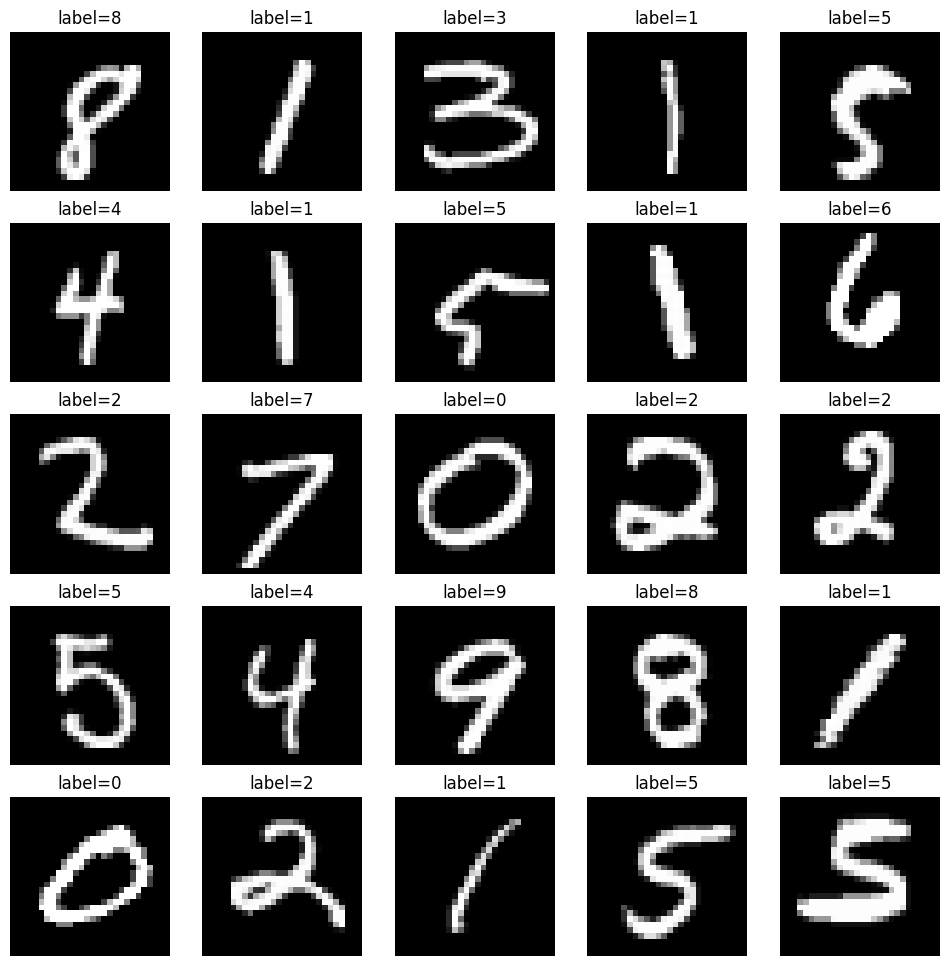

In [13]:
test_batch = test_ds.as_numpy_iterator().next()
pred = pred_step(state, test_batch)

fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(test_batch['image'][i, ..., 0], cmap='gray')
  ax.set_title(f'label={pred[i]}')
  ax.axis('off')

Congratulations! You made it to the end of the annotated MNIST example.